In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np

import rasterio

import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [5]:
from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

In [6]:
gdf = gpd.read_file('../data/processed/cerro_garcia/Propuesta_Cerro_Garcia_DPI23_UTM_v4.geojson')
gdf = gdf.to_crs("EPSG:4326")
hex_gdf = aup.create_hexgrid(gdf, 11)
hex_gdf = hex_gdf[['hex_id_11','geometry']]
hex_gdf = hex_gdf.to_crs("EPSG:32613")
print(hex_gdf.shape)
hex_gdf.head(4)

(133846, 2)


,hex_id_11,geometry
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2..."
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2..."
2,8b49aa328333fff,"POLYGON ((663808.589 2232662.514, 663826.475 2..."
3,8b49aa0e1236fff,"POLYGON ((697994.599 2226345.892, 698012.482 2..."


In [7]:
hex_gdf.crs

<Derived Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
grl_dir = '../data/processed/cerro_garcia/'

## Function mask

In [9]:
def clean_mask(geom, dataset='', **mask_kw):
    """
    The mask in this function is used to extract the values from a raster dataset that fall 
    within a given geometry of interest.

    Arguments:
        geom (geometry): Geometric figure that will be used to mask the raster dataset.
        dataset (rasterio DatasetReader): The raster dataset that will be masked by the 
        inputted geometry. If no value is provided, then it defaults to an empty string 
        and returns only the masked array of values from within the inputted geometry 
        without any metadata.
        mask_kw (dict): A dictionary of arguments passed to create the mask.

    Returns:
        masked (np.array): Returns values from within the inputted geometry.
    """
    try:
        mask_kw.setdefault('crop', True)
        mask_kw.setdefault('all_touched', True)
        mask_kw.setdefault('filled', False)
        masked, _ = rasterio.mask.mask(dataset=dataset, shapes=(geom,),
                                      **mask_kw)
    except:
        masked = np.nan
    return masked

## Valor para los recursos naturales

Hidrología

In [10]:
raster_file = rasterio.open(grl_dir + 'IdxHidrologia_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_hidrologia'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

try:
    hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: aup.clean_mask(geom,raster_file)).apply(np.ma.mean)
except:
    hex_gdf[col_name] = np.nan
print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 3)


,hex_id_11,geometry,idx_hidrologia
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821


In [11]:
raster_file

<open DatasetReader name='../data/processed/cerro_garcia/IdxHidrologia_AMC_CerroGarcia_UTM_v1.tif' mode='r'>

<AxesSubplot: >

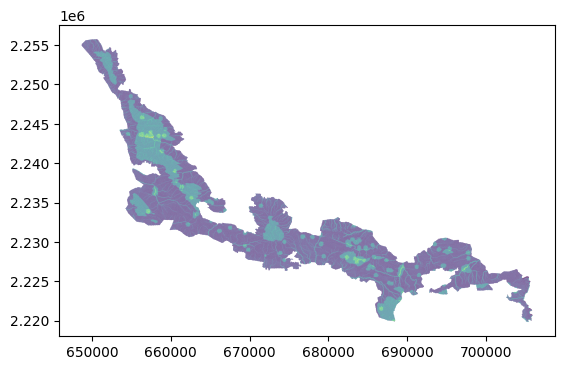

In [12]:
hex_gdf.plot(col_name)

Cobertura vegetal

In [13]:
raster_file = rasterio.open(grl_dir + 'IdxCoberturaVegetal_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_coberturavegetal'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 4)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454


<AxesSubplot: >

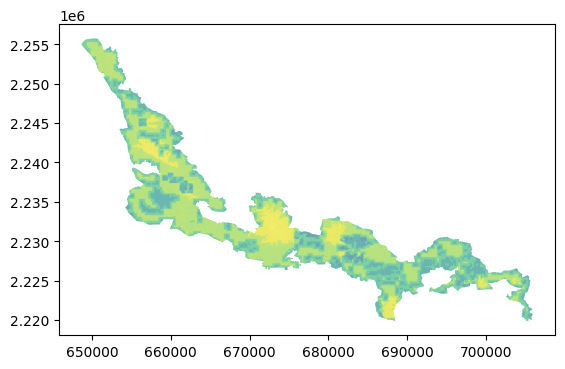

In [14]:
hex_gdf.plot(col_name)

Biodiversidad

In [15]:
raster_file = rasterio.open(grl_dir + 'IdxBiodiversidad_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_biodiversidad'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 5)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667


<AxesSubplot: >

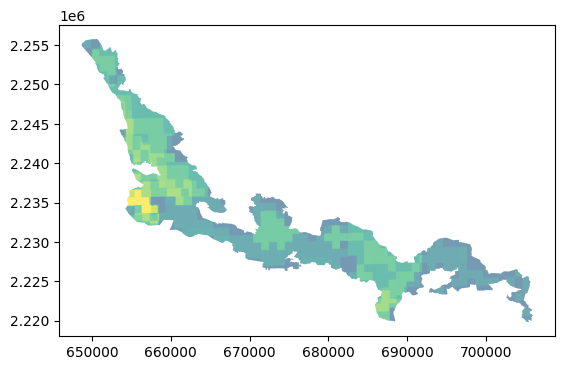

In [16]:
hex_gdf.plot(col_name)

Políticas

In [17]:
raster_file = rasterio.open(grl_dir + 'IdxPOER_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_politica'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 6)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5


<AxesSubplot: >

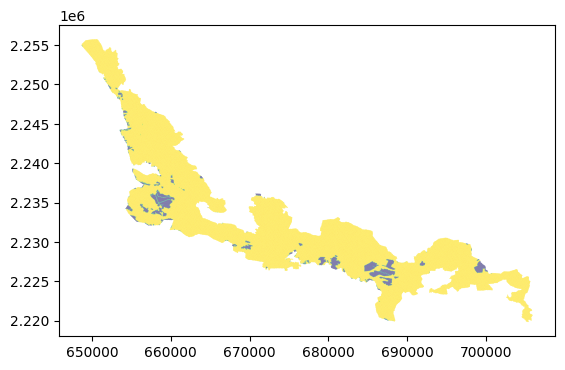

In [18]:
hex_gdf.plot(col_name)

Edafología

In [19]:
raster_file = rasterio.open(grl_dir + 'IdxEdafologia_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_edafologia'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 7)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5


<AxesSubplot: >

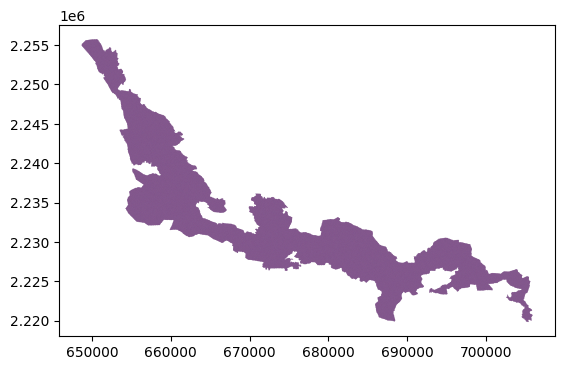

In [20]:
hex_gdf.plot(col_name)

Índice

In [21]:
raster_file = rasterio.open(grl_dir + 'IdxValorRecursosNaturales_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_valor_recursos_naturales'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 8)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385


<AxesSubplot: >

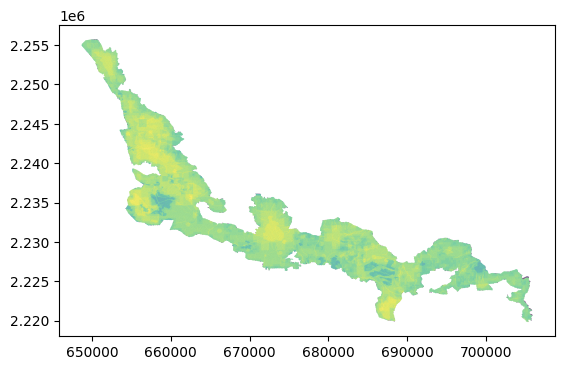

In [22]:
hex_gdf.plot(col_name)

## Aprovechamiento y uso cultural

Agricola

In [23]:
raster_file = rasterio.open(grl_dir + 'InvIdxAgricola_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_agricola'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 9)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0


<AxesSubplot: >

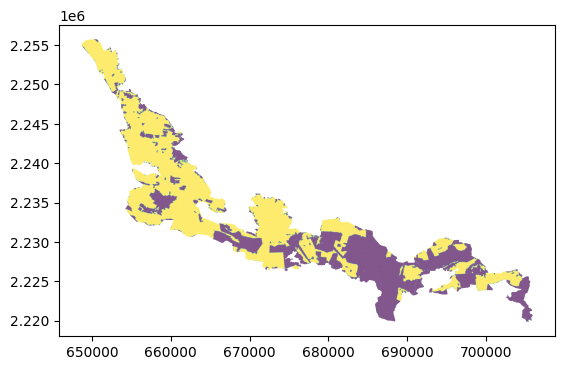

In [24]:
hex_gdf.plot(col_name)

Pertenencia

In [25]:
raster_file = rasterio.open(grl_dir + 'IdxPertenencia_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_pertenencia'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 10)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000


<AxesSubplot: >

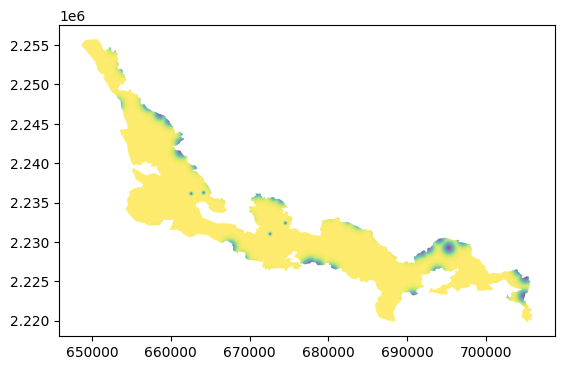

In [26]:
hex_gdf.plot(col_name)

Recreativo

In [27]:
raster_file = rasterio.open(grl_dir + 'IdxRecreativo_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_recreativo'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 11)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0


<AxesSubplot: >

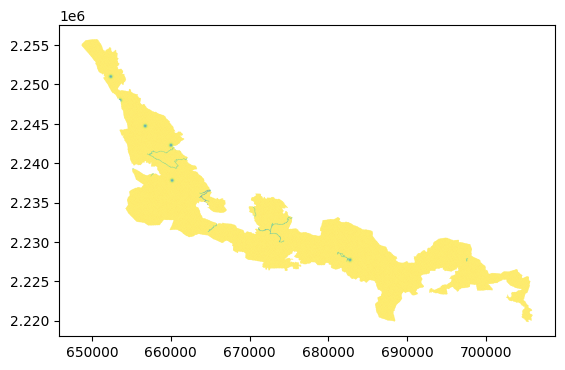

In [28]:
hex_gdf.plot(col_name)

Índice

In [29]:
raster_file = rasterio.open(grl_dir + 'IdxAprovechamientoUsoCultural_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_aprovechamiento_cultural'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 12)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667


<AxesSubplot: >

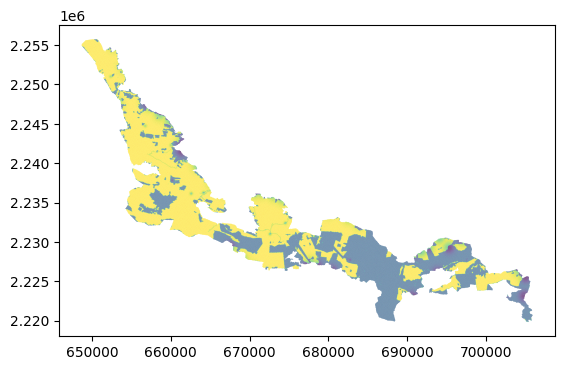

In [30]:
hex_gdf.plot(col_name)

## Degradación

Degradación de cobertura vegetal

In [31]:
raster_file = rasterio.open(grl_dir + 'IdxDegradacionCoberturaVegetal_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_degradacion_cobertura_vegetal'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 13)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169


<AxesSubplot: >

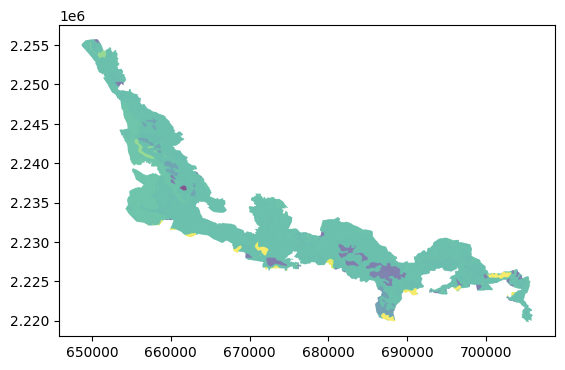

In [32]:
hex_gdf.plot(col_name)

Cambio de NDVI

In [33]:
raster_file = rasterio.open(grl_dir + 'IdxTendNDVI_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_cambio_ndvi'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 14)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500,1.0
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169,1.0


<AxesSubplot: >

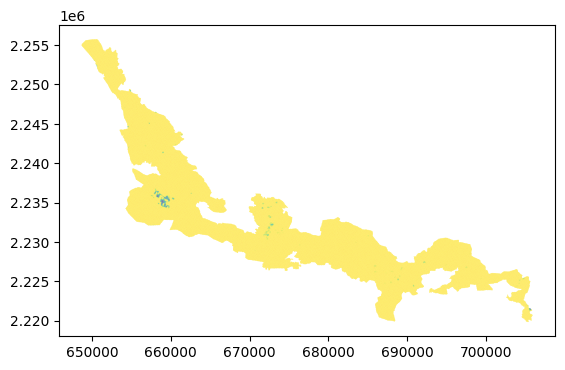

In [34]:
hex_gdf.plot(col_name)

Impacto antropogénico

In [35]:
raster_file = rasterio.open(grl_dir + 'InvIdxImpactoAntropogenico_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_impacto_antropogenico'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 15)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500,1.0,0.124227
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169,1.0,0.173280


<AxesSubplot: >

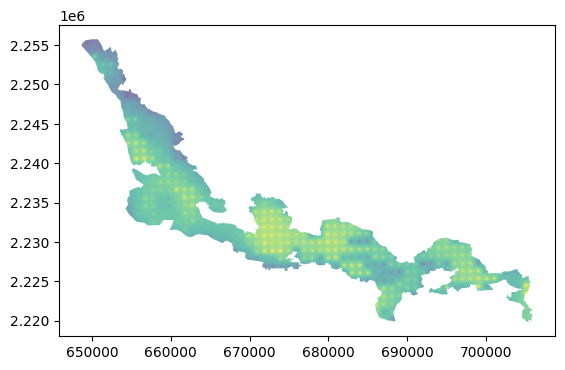

In [36]:
hex_gdf.plot(col_name)

Erosión

In [37]:
raster_file = rasterio.open(grl_dir + 'IdxErosion_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_erosion'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 16)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500,1.0,0.124227,0.495735
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169,1.0,0.173280,0.733339


<AxesSubplot: >

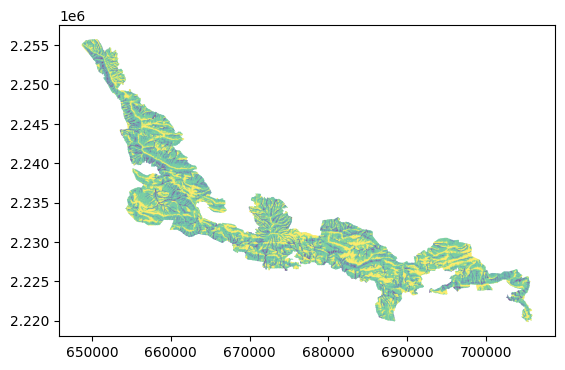

In [38]:
hex_gdf.plot(col_name)

Índice

In [39]:
raster_file = rasterio.open(grl_dir + 'IdxDegradacion_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_degradacion'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 17)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500,1.0,0.124227,0.495735,0.655952
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169,1.0,0.173280,0.733339,0.523116


<AxesSubplot: >

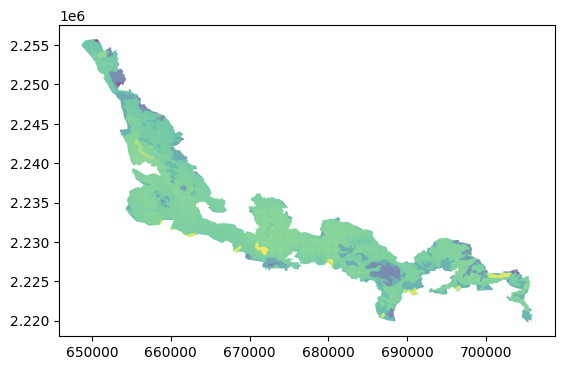

In [40]:
hex_gdf.plot(col_name)

## Riesgos

Erosión potencial

In [41]:
raster_file = rasterio.open(grl_dir + 'InvIdxErosionPotencial_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_erosion_potencial'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 18)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500,1.0,0.124227,0.495735,0.655952,1.00
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169,1.0,0.173280,0.733339,0.523116,0.75


<AxesSubplot: >

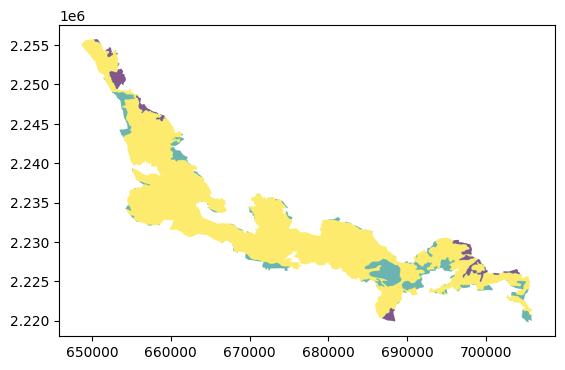

In [42]:
hex_gdf.plot(col_name)

Incendios

In [43]:
raster_file = rasterio.open(grl_dir + 'IdxIncendios_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_incendios'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 19)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial,idx_incendios
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500,1.0,0.124227,0.495735,0.655952,1.00,0.000000
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169,1.0,0.173280,0.733339,0.523116,0.75,0.001259


<AxesSubplot: >

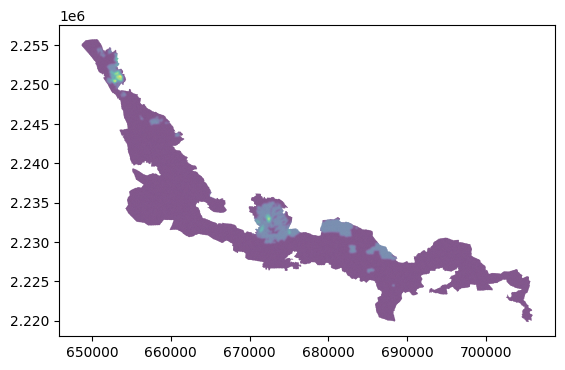

In [44]:
hex_gdf.plot(col_name)

Proximidad a entornos urbanos

In [45]:
raster_file = rasterio.open(grl_dir + 'InvIdxProximidadEntornos_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_proximidad_entornos_urbanos'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 20)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial,idx_incendios,idx_proximidad_entornos_urbanos
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,0.990429,0.500,1.0,0.124227,0.495735,0.655952,1.00,0.000000,0.011816
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,0.666667,0.169,1.0,0.173280,0.733339,0.523116,0.75,0.001259,0.200000


<AxesSubplot: >

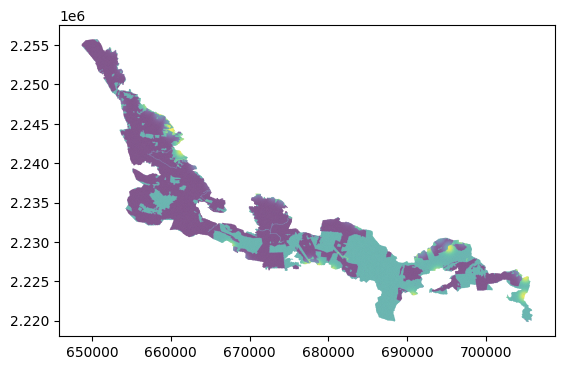

In [46]:
hex_gdf.plot(col_name)

Índice

In [47]:
raster_file = rasterio.open(grl_dir + 'IdxRiesgos_AMC_CerroGarcia_UTM_v1.tif')
col_name = 'idx_riesgos'
hex_gdf = hex_gdf.to_crs(raster_file.crs)

hex_gdf[col_name] = hex_gdf.geometry.apply(lambda geom: clean_mask(geom,raster_file)).apply(np.ma.mean)

print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 21)


,hex_id_11,geometry,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,...,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial,idx_incendios,idx_proximidad_entornos_urbanos,idx_riesgos
0,8b49aa34355cfff,"POLYGON ((656968.694 2246226.723, 656986.582 2...",0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,...,0.990429,0.500,1.0,0.124227,0.495735,0.655952,1.00,0.000000,0.011816,0.502330
1,8b49aa04e0b6fff,"POLYGON ((685155.909 2226765.182, 685173.793 2...",0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,...,0.666667,0.169,1.0,0.173280,0.733339,0.523116,0.75,0.001259,0.200000,0.510475


<AxesSubplot: >

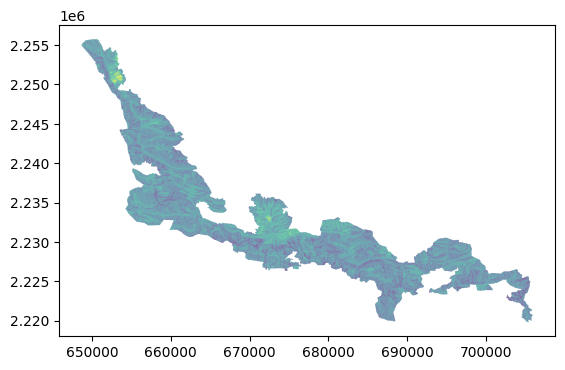

In [48]:
hex_gdf.plot(col_name)

## Save file

In [49]:
hex_gdf.to_file('../data/processed/cerro_garcia/hex_amc_utm_v1.geojson')

## K-means model

In [50]:
hex_gdf = hex_gdf.fillna(0)

In [51]:
data = hex_gdf.drop(columns=['hex_id_11','geometry']).to_numpy()

In [52]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
# 9 categorías de zonificación

kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

In [ ]:
hex_gdf['cluster'] = clusters
hex_gdf.plot('cluster', legend=True)

In [ ]:
hex_gdf.groupby('cluster').mean()

In [ ]:
sns.heatmap(hex_gdf.groupby('cluster').mean(), 
            annot=False,fmt=".1f", linewidth=.5, cmap="crest")